### Indian_Diabetes_Data
> 인디언의 여러 환경 요소가 당뇨병에 미치는 영향을 알아보고, 나아가 당뇨병의 여부를 예측하고자 한다.

### 데이터 변수명 참고
- Pregnancies : 임신 횟수
- Glucose : 포도당 부하 검사 수치
- BloodPressure : 혈압(mm Hg)
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- Insulin : 혈청 인슐린(mu U/ml)
- BMI : 체질량지수 (체중(kg) / 키(m)^2)
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값
- Age : 나이 > 구간화하자
- Outcome : 클래스 결정 값 (0 또는 1)

### 분석절차
- 

In [1]:
# 분석
import pandas as pd
import numpy as np
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
#머신러닝
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report,precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action = "ignore")

In [4]:
df = pd.read_csv("ml_exam/diabetes/diabetes.csv")
print(df.shape)
print(df.info())
print(df.head())
print(df["Outcome"].value_counts())    # 정상:당뇨 = 2:1 (약)

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2         

>- 주어진 데이터는 모두 수치형이다.
>- 결측치가 존재하지 않는다.

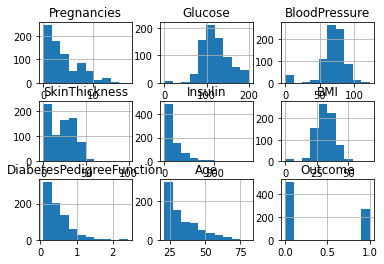

In [5]:
df.hist()
plt.show()

>- Glucose, BloodPressure, BMI 에서 0이 관측된다. (이상치 의심)
>- Age 구간화 필요
>- 데이터가 편중
>- target feature : Outcome

In [7]:
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]
print(X.head(), y.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33   0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64


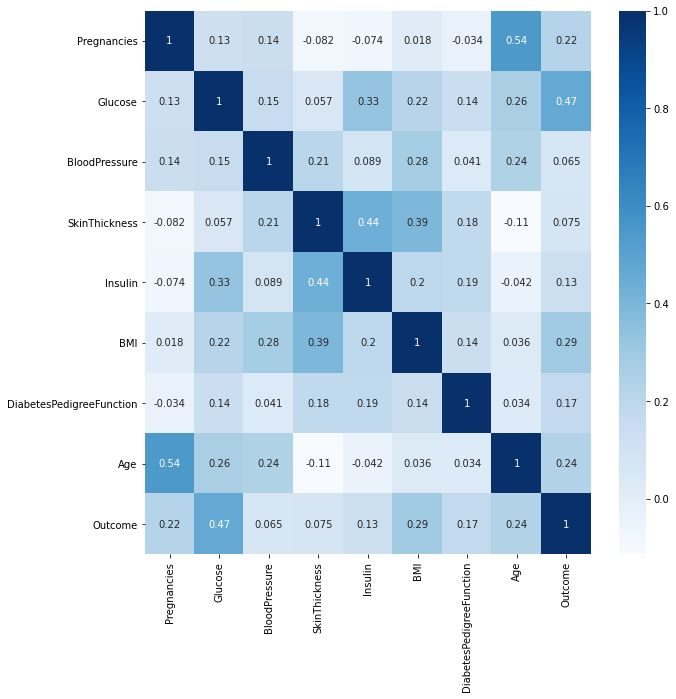

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), annot = True, fmt = ".2g", cmap = "Blues")
plt.show()

>- Pregnancies, Glucose, BMI, Age 주요 항목
>- DiabetesPedigreeFunction은 상대적으로 낮은 상관도를 보인다.

In [63]:
def get_score(y_test, pred, str = None):
    print("------{}-------".format(str))
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print("정확도 {:.4f}  f1 {:.4f}  정밀도 {:.4f}  재현율 {:.4f}  roc_auc {:.4f}".format(acc, f1, precision, recall, roc_auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print(cf_matrix)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 121)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred, "최초점수")

------최초점수-------
정확도 0.8182  f1 0.7143  정밀도 0.7955  재현율 0.6481  roc_auc 0.7791
[[91  9]
 [19 35]]


> 재현율(당뇨병 환자 중 실제로 양성 판정을 받은 경우)이 60% 초중반 밖에 안된다.

### 전처리 Data Preprocessing / 피쳐가공(Feature Engineering)
-Scaler(정규화, 스케일링), outlier(이상치), 피쳐 병합 및 삭제, 구간화(범주화)

In [10]:
for col in X.columns:
    cnt = X[col][X[col]==0].count()
    print(col, cnt, np.round(cnt/X.shape[0]*100, 2))

Pregnancies 111 14.45
Glucose 5 0.65
BloodPressure 35 4.56
SkinThickness 227 29.56
Insulin 374 48.7
BMI 11 1.43
DiabetesPedigreeFunction 0 0.0
Age 0 0.0


In [11]:
print(X[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].describe())

          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   79.799479   31.992578
std     31.972618      19.355807      15.952218  115.244002    7.884160
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000    0.000000   27.300000
50%    117.000000      72.000000      23.000000   30.500000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


In [95]:
zero_col = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
zero_col_median = X[zero_col].median().round(1)
X[zero_col] = X[zero_col].replace(0, zero_col_median)
print(X[zero_col].describe()) 

rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred, "0 처리 후 점수")

          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   121.656250      72.386719      27.334635   94.652344   32.450911
std     30.438286      12.096642       9.229014  105.547598    6.875366
min     44.000000      24.000000       7.000000   14.000000   18.200000
25%     99.750000      64.000000      23.000000   30.500000   27.500000
50%    117.000000      72.000000      23.000000   31.250000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000
------0 처리 후 점수-------
정확도 0.8377  f1 0.7475  정밀도 0.8222  재현율 0.6852  roc_auc 0.8026
[[92  8]
 [17 37]]


>- 이상치(0인항목)를 중앙값을 이용하여 대체하였다.
>- 재현율 60% 중후반으로 다소 증가하였다.

In [81]:
X["Age_cate"] = X["Age"].apply(lambda x : int(x//10))
print(X[["Age_cate", "Age"]])
X = pd.get_dummies(data = X , columns = ["Age_cate"], prefix = "OH_Age_cate")
print(X.info())
print(X.head())

     Age_cate  Age
0           5   50
1           3   31
2           3   32
3           2   21
4           3   33
..        ...  ...
763         6   63
764         2   27
765         3   30
766         4   47
767         2   23

[768 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   OH_Age_cate_2             768 non-null    uint8  
 9   OH_Age_cate_3             768 non

> OH_Age_cate2 : 주어진 데이터에서 가장 어린 사람은 27살이다.

In [92]:
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred, "나이 구간화,원핫인코딩 후 점수")

------나이 구간화,원핫인코딩 후 점수-------
정확도 0.8117  f1 0.7071  정밀도 0.7778  재현율 0.6481  roc_auc 0.7741
[[90 10]
 [19 35]]


In [99]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size = 0.2, random_state = 121)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
get_score(y_test, pred, "스케일링 된 점수") 

------스케일링 된 점수-------
정확도 0.8506  f1 0.7677  정밀도 0.8444  재현율 0.7037  roc_auc 0.8169
[[93  7]
 [16 38]]


56 56 55


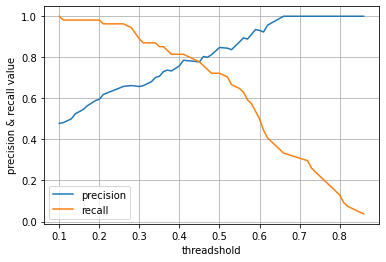

In [100]:
proba = rf_model.predict_proba(X_test)    # 0 또는 1이 나올 각각의 확률, 같을때는 0
precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
print(len(precision), len(recall), len(th))    # 개수 차이가 있으므로 개수를 맞춘후에 차트를 그려보자

plt.plot(th, precision[:len(th)], label = "precision")
plt.plot(th, recall[:len(th)], label = "recall")
plt.xlabel("threadshold")
plt.ylabel("precision & recall value")
plt.legend()
plt.grid()
plt.show() 

> 임계치가 약 0.45 수준이다

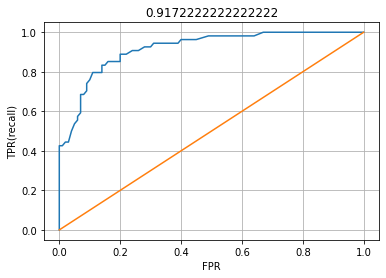

In [105]:
## roc_curve : FPR/ TPR 비율
fpr, tpr, th = roc_curve(y_test, proba[:,1])
auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
plt.plot(fpr, tpr, label = "ROC")
plt.plot([0,1], [0,1], label = "th:0.5")
plt.title(auc)
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.grid()
plt.show()

In [102]:
my_th = [.4, .43, .45, .47, .49, .51, .53]
for th in my_th:
    print("N : P", th, 1-th)
    rf_model.fit(X_train, y_train)
    pred = rf_model.predict(X_test)
    proba = rf_model.predict_proba(X_test)
    get_score(y_test, pred)

    bn = Binarizer(threshold = th)    # 임계치를 기준으로 >>> 여기서는 0보다 크면 1 작으면 0이다.
    fit_trans = bn.fit_transform(proba[:,1].reshape(-1,1))
    auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))
    print(auc)

N : P 0.4 0.6
------None-------
정확도 0.8312  f1 0.7174  정밀도 0.8684  재현율 0.6111  roc_auc 0.7806
[[95  5]
 [21 33]]
0.9220370370370371
N : P 0.43 0.5700000000000001
------None-------
정확도 0.8377  f1 0.7423  정밀도 0.8372  재현율 0.6667  roc_auc 0.7983
[[93  7]
 [18 36]]
0.9185185185185185
N : P 0.45 0.55
------None-------
정확도 0.8442  f1 0.7600  정밀도 0.8261  재현율 0.7037  roc_auc 0.8119
[[92  8]
 [16 38]]
0.919074074074074
N : P 0.47 0.53
------None-------
정확도 0.8701  f1 0.7917  정밀도 0.9048  재현율 0.7037  roc_auc 0.8319
[[96  4]
 [16 38]]
0.9263888888888889
N : P 0.49 0.51
------None-------
정확도 0.8377  f1 0.7475  정밀도 0.8222  재현율 0.6852  roc_auc 0.8026
[[92  8]
 [17 37]]
0.9197222222222222
N : P 0.51 0.49
------None-------
정확도 0.8312  f1 0.7347  정밀도 0.8182  재현율 0.6667  roc_auc 0.7933
[[92  8]
 [18 36]]
0.9216666666666667
N : P 0.53 0.47
------None-------
정확도 0.8247  f1 0.7158  정밀도 0.8293  재현율 0.6296  roc_auc 0.7798
[[93  7]
 [20 34]]
0.9172222222222222


In [104]:
# 데이터 적은 경우 >> 데이터 증강 K-Fold, st.K-Fold, cross_val_score, GridSearchCV
# 데이터 증강 후 튜닝 GridSearchCV

my_score={"acc":"accuracy", "f1":"f1"}

my_hyper_param = {  "n_estimators"      :[100] ,
                    "max_depth"        :[7,9,11],
                    "min_samples_leaf" :[3,5,7,9],
                    "random_state" : [121,]
                 }

gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)

gcv_model.fit(X_train, y_train)
# predict : 시험
print("best_estimator_", gcv_model.best_estimator_)
print("best_params_",    gcv_model.best_params_)
print("best_score_" ,    gcv_model.best_score_)

print("GridSearchCV 평균 정확도 : " , gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
print("GridSearchCV 평균 F1 : "    , gcv_model.cv_results_["mean_test_f1"].mean())

gcv_df = pd.DataFrame(gcv_model.cv_results_)
print(gcv_df.info())
print("GridSearchCV 평균 정확도 : " , gcv_df["mean_test_acc"].mean())
print("GridSearchCV 평균 F1 : "    , gcv_df["mean_test_f1"].mean())

best_estimator_ RandomForestClassifier(max_depth=9, min_samples_leaf=5, random_state=121)
best_params_ {'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 121}
best_score_ 0.5989799477085107
GridSearchCV 평균 정확도 :  0.7373972633168955
GridSearchCV 평균 F1 :  0.5810624465147757
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean_fit_time           12 non-null     float64
 1   std_fit_time            12 non-null     float64
 2   mean_score_time         12 non-null     float64
 3   std_score_time          12 non-null     float64
 4   param_max_depth         12 non-null     object 
 5   param_min_samples_leaf  12 non-null     object 
 6   param_n_estimators      12 non-null     object 
 7   param_random_state      12 non-null     object 
 8   params                  12 non-null     object 
 9   split0_tes

### 결과가 매우 좋지 않다. 상단에서 나온 결과는 오버 피팅임을 알 수 있다.